# Getting Started with Minerva for Seismic Facies Segmentation

Seismic Facies Classification is a challenging problem in the field of geophysics. The goal is to predict the lithology of the subsurface based on seismic data. In this notebook, we will use the Minerva to train and evaluate a DeepLabV3 model from scratch for seismic facies classification.

Thus, this notebook is a step-by-step guide to train a DeepLabV3 model for seismic facies classification using Minerva. It comprises the following steps:

1. Data Preparation
2. Model Creation
3. Model Training
4. Model Evaluation

## Imports

In [1]:
from pathlib import Path
import numpy as np
from minerva.data.readers.patched_array_reader import NumpyArrayReader
from minerva.data.data_modules.base import MinervaDataModule
from minerva.transforms.transform import Repeat, Squeeze
from minerva.data.datasets.base import SimpleDataset
from minerva.models.nets.image.deeplabv3 import DeepLabV3
import lightning as L
import torch
from torchmetrics import JaccardIndex
import matplotlib.pyplot as plt

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Preparation

We begin by preparing the data for training and evaluation.

For this tutorial, we will use the [F3 dataset](https://zenodo.org/records/3755060/files/data.zip?download=1) from the seismic facies classification benchmark, introduced in the following work:

```latex
Alaudah, Y., Michałowicz, P., Alfarraj, M. and AlRegib, G., 2019. A machine-learning benchmark for facies classification. Interpretation, 7(3), pp.SE175-SE187.
```

This dataset is a 3D seismic volume from the F3 block in the Netherlands North Sea. It will be downloaded and unzipped in the following cell, at `datasets/f3/` directory.

In [2]:
!wget https://zenodo.org/records/3755060/files/data.zip?download=1 -O f3.zip
!mkdir -p datasets/f3
!unzip -o f3.zip -d datasets/f3
!rm f3.zip

--2025-06-09 13:02:19--  https://zenodo.org/records/3755060/files/data.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1051449986 (1003M) [application/octet-stream]
Saving to: ‘f3.zip’

f3.zip              100%[===================>]   1003M  2.35MB/s    in 7m 39s  

2025-06-09 13:10:00 (2.18 MB/s) - ‘f3.zip’ saved [1051449986/1051449986]

Archive:  f3.zip
   creating: datasets/f3/data/
   creating: datasets/f3/data/train/
  inflating: datasets/f3/data/train/train_seismic.npy  
  inflating: datasets/f3/data/train/train_labels.npy  
   creating: datasets/f3/data/test_once/
  inflating: datasets/f3/data/test_once/test1_seismic.npy  
  inflating: datasets/f3/data/test_once/test2_labels.npy  
  inflating: datasets/f3/data/test_once/test1_labels.npy  
  inflating: datasets/f3/data/test_once/test2_seismic.npy  
  i

Once extracted, the data is organized as follows:

```tree
f3/data/
├── test_once
│   ├── test1_labels.npy
│   ├── test1_seismic.npy
│   ├── test2_labels.npy
│   └── test2_seismic.npy
└── train
    ├── train_labels.npy
    └── train_seismic.npy
```

The `train` folder contains the training data, while the `test_once` folder holds the test data. Each sample is stored in two separate NumPy files: one for the seismic volume and one for the corresponding labels.

Each `.npy` file contains a 3D volume with the following dimensions:

- `train_seismic`: `(401, 701, 255)` — where `(401, 701)` are the spatial dimensions, and `255` is the number of seismic traces.  
- `test1_seismic`: `(200, 701, 255)` — same trace dimension, but fewer spatial slices.  
- `test2_seismic`: `(601, 200, 255)` — different spatial dimensions from training and Test 1.

**Note**: The label volumes have the same shapes as their corresponding seismic volumes.

To process the data, we iterate over the first dimension of the seismic volumes to extract 2D slices and their associated labels. For example, for the training data, we extract `401` slices of shape `(701, 255)` each, along with their matching label slices of the same shape.

It's important to note that Test 1 samples have the same spatial dimensions as the training set, making it suitable for direct evaluation. Test 2, however, has different spatial dimensions and may require separate handling. Thus, we will focus on Test 1 for evaluation in this notebook.

Each label slice is a 2D array containing 6 distinct classes, representing different lithologies.

## 1.1 Creating Data Readers and Dataset

In Minerva, we can create readers, which are responsible for loading a single unit of data in a ordered way. It is like an ordered collection of data. A Dataset is a collection of readers and transforms, associated to each reader.

Let's first create 2 readers for training data. The first reader will be responsible to iterate over the training seismic data, while the second reader will iterate over the corresponding labels.

We will use `NumpyArrayReader` that allows use to read data from NumPy files.
There are two required arguments for `NumpyArrayReader`:
- `data`: the path to the NumPy file or the NumPy array.
- `data_shape`: the shape of each sample. We will use `(1, 701, 255)` for seismic data and `(1, 701, 255)` for labels. Thus, the shape of each sample will be `(1, 701, 255)` and we will have 401 samples for training data.

In [3]:
root_data_dir = Path("datasets/f3/data/")

train_data_reader = NumpyArrayReader(
    data=root_data_dir / "train" / "train_seismic.npy",
    data_shape=(1, 701, 255),
)

train_labels_reader = NumpyArrayReader(
    data=root_data_dir / "train" / "train_labels.npy",
    data_shape=(1, 701, 255),
)

Once the readers are set up, we can create a dataset using them. For this purpose, we'll use the `SimpleDataset` class, which takes two main inputs:

- A list of **readers** (data sources)  
- A list of **transforms** (optional preprocessing steps)

When an item at index `i` is requested from the dataset (e.g., `dataset[i]`), the following steps occur:

1. The dataset retrieves the item at index `i` from `reader[0]` and applies the corresponding transform `transform[0]`.
2. It then retrieves the item at index `i` from `reader[1]` and applies `transform[1]`.
3. Finally, it returns a 2-element tuple containing the transformed outputs:
   - The first element is the transformed seismic data: `transform[0](reader[0][i])`
   - The second element is the transformed label: `transform[1](reader[1][i])`

This design enables flexible and consistent pairing of multiple data sources with their corresponding preprocessing logic-ideal for training, validation, or testing workflows.


We will use the following transforms:
- For seismic data: as data is uni-dimensional, and our model expects RGB data, we will convert the seismic data to a 3-channel image by repeating the same data across 3 channels. Thus, we will use `Repeat` transform, and our data will be of shape `(3, 701, 255)`.
- For labels: we will use no transforms. The data will be of shape `(1, 701, 255)`.

In [4]:
train_dataset = SimpleDataset(
    readers=[
        train_data_reader,  # 1st reader is the data
        train_labels_reader # 2nd reader is the labels
    ],
    transforms=[
        Repeat(axis=0, n_repetitions=3),  # Transforms to first reader (data)
        None                              # Transforms to second reader (labels)
    ],
)

print(train_dataset)

           📂 SimpleDataset Information            
📌 Dataset Type: SimpleDataset
   └── Reader 0: NumpyArrayReader(samples=401, shape=(1, 701, 255), dtype=float64)
   │     └── Transform: Repeat(axis=0, n_repetitions=3)
   └── Reader 1: NumpyArrayReader(samples=401, shape=(1, 701, 255), dtype=uint8)
   │     └── Transform: None
   │
   └── Total Readers: 2


The same will be done for the test data. However, the only difference will be at test label transform. We do not want the channels dimension for the labels. Thus, the shape of the label data will be `(701, 255)`. Thus, we will use `Squeeze` transform to remove the channels dimension. For the seismic data, we will use the same transform as the training data.

In [5]:
test_data_reader = NumpyArrayReader(
    data=root_data_dir / "test_once" / "test1_seismic.npy",
    data_shape=(1, 701, 255),
)

test_labels_reader = NumpyArrayReader(
    data=root_data_dir / "test_once" / "test1_labels.npy",
    data_shape=(1, 701, 255),
)

test_dataset = SimpleDataset(
    readers=[test_data_reader, test_labels_reader],
    transforms=[Repeat(axis=0, n_repetitions=3), Squeeze(0)],
)

print(test_dataset)

           📂 SimpleDataset Information            
📌 Dataset Type: SimpleDataset
   └── Reader 0: NumpyArrayReader(samples=200, shape=(1, 701, 255), dtype=float64)
   │     └── Transform: Repeat(axis=0, n_repetitions=3)
   └── Reader 1: NumpyArrayReader(samples=200, shape=(1, 701, 255), dtype=uint8)
   │     └── Transform: Squeeze(axis=0)
   │
   └── Total Readers: 2


### 1.2. Creating the `MinervaDataModule`

Minerva models are implemented using Pytorch Lightning. 
Thus, to train a model we should create a `LightningDataModule` object that will handle the data loading and preprocessing.
Minerva provides a `MinervaDataModule` class that extends Pytorch Lightning's `LightningDataModule` class and standardizes the data loading process.

We may create a `MinervaDataModule` object by passing the training, validation, and testing datasets, as well as the batch size and the number of workers for data loading.

We use `drop_last` parameter to drop the last batch if it is smaller than the batch size. This is quite useful as DeepLabV3 model expects the batch is higher than 1.

In [6]:
data_module = MinervaDataModule(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=16,
    num_workers=4,
    additional_train_dataloader_kwargs={"drop_last": True},
    name="F3 Dataset"
)

print(data_module)

                    🆔 F3 Dataset
└── Predict Split: test
📂 Datasets:
   ├── Train Dataset:
   │      ==================================================
   │                 📂 SimpleDataset Information            
   │      ==================================================
   │      📌 Dataset Type: SimpleDataset
   │         └── Reader 0: NumpyArrayReader(samples=401, shape=(1, 701, 255), dtype=float64)
   │         │     └── Transform: Repeat(axis=0, n_repetitions=3)
   │         └── Reader 1: NumpyArrayReader(samples=401, shape=(1, 701, 255), dtype=uint8)
   │         │     └── Transform: None
   │         │
   │         └── Total Readers: 2
   │      ==================================================
   ├── Val Dataset:
   │      None
   └── Test Dataset:
                     📂 SimpleDataset Information            
          📌 Dataset Type: SimpleDataset
             └── Reader 0: NumpyArrayReader(samples=200, shape=(1, 701, 255), dtype=float64)
             │     └── Transform: Rep

## 2. Creating the Model


For this tutorial, we will use a DeepLabV3 model for seismic facies classification. The DeepLabV3 model is a popular architecture for semantic segmentation tasks, such as image segmentation. It is based on a deep convolutional neural network with a ResNet backbone and an Atrous Spatial Pyramid Pooling (ASPP) module. Minerva provides a `DeepLabV3` model that can be used for seismic facies classification. We just need to pass the number of classes to the model, which is 6 in this case.

In [7]:
model = DeepLabV3(num_classes=6)
model

DeepLabV3(
  (backbone): DeepLabV3Backbone(
    (RN50model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu)

## 3. Defining the trainer

As we are using Pytorch Lightning, we need to define a `Trainer` object to train the model.
We can define the trainer by passing the following parameters:
- `max_epochs`: Maximum number of epochs to train the model.
- `acceleartor`: Device to use for training. It can be `cpu` or `gpu`.
- `devices`: the list or the number of accelerator to use for training.

For this example we will disable logging and checkpointing, by setting `logger=False` and `checkpoint_callback=False`.

In [8]:
trainer = L.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    logger=False,
    enable_checkpointing=False,
)

trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## 3.1. Training the model

To train the model we need to have three objects: the model, the data module, and the trainer.
We can train the model by calling the `fit` method from the trainer and passing the model and the data module.

The `fit` method will train the model for the number of epochs defined in the trainer object. Also, training dataloader will be used for training, and validation dataloader will be used for validation.

In [9]:
trainer.fit(model, data_module)

/home/vscode/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX 5000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                    | Params | Mode 
-------------------------------------------------------------
0 | backbone | DeepLabV3Backbone       | 25.6 M | train
1 | fc       | DeepLabV3PredictionHead | 16.1 M | train
2 | loss_fn  | CrossEntropyLoss        | 0      | train
-------------------------------------------------------------
41.7 M    Trainable params
0         Non-trainable 

Epoch 0:   0%|          | 0/25 [00:00<?, ?it/s] 

/home/vscode/.local/lib/python3.10/site-packages/lightning/pytorch/core/module.py:512: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 99: 100%|██████████| 25/25 [00:11<00:00,  2.13it/s, train_loss=0.0113]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 25/25 [00:11<00:00,  2.13it/s, train_loss=0.0113]


## 4. Evaluating Model

Once model is trained, we can evaluate the performance of the model on the test dataset.
The performance is evaluated using the mIoU metric.

To evaluate the model, we perform the following steps:
1. Perform inference on the test dataset using the trained model. This is done using the `trainer.predict` method. The method returns the predicted logits for each sample in the test dataset.
2. Calculate the predicted labels by taking the argmax of the logits.
3. Obtain the labels from the test dataset.
4. Create the accuracy metric object and pass the predicted labels and the true labels.

In [10]:
# 1. Obtain predictions for the test set
predictions = trainer.predict(model, data_module)
# As predictions is a list of batches, we concatenate them along the first dimension
predictions = torch.cat(predictions, dim=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 13/13 [00:03<00:00,  4.28it/s]


In [11]:
# 2. We an use the torch.argmax function to obtain the class with the highest probability
predicted_classes = torch.argmax(predictions, dim=1)
# Let's print the predicted classes
print(f"The shape of the predicted labels is {predicted_classes.shape} and dtype {predicted_classes.dtype}")

The shape of the predicted labels is torch.Size([200, 701, 255]) and dtype torch.int64


In [12]:
# 3. Let's obtain the true labels
test_samples = np.array([y for _, y in data_module.test_dataset])
y = torch.from_numpy(test_samples).long()

# Let's print the true labels
print(f"The shape of the true labels is {y.shape} and dtype {y.dtype}")

The shape of the true labels is torch.Size([200, 701, 255]) and dtype torch.int64


In [13]:
# 4. Let's create the accuracy metric object and compute the accuracy
jaccard = JaccardIndex(task="multiclass", num_classes=6)
score = jaccard(predicted_classes, y)
print(f"The mIoU of the model is {score.item()*100:.2f}%")

The mIoU of the model is 71.87%


### 4.1. Visualizing the Predictions

We can also visualize the predictions made by the model on the test dataset. 

We will visualize inline number 100 using Matplotlib.

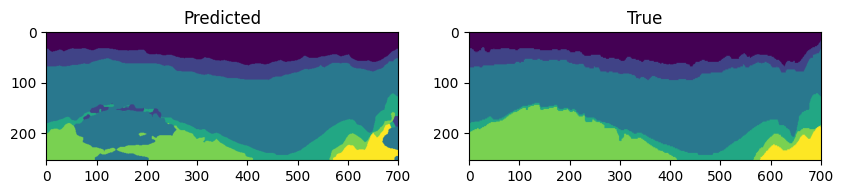

In [14]:
index = 100
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(predicted_classes[index].cpu().numpy().T)
axes[0].set_title("Predicted")
axes[1].imshow(y[index].cpu().numpy().T)
axes[1].set_title("True")
plt.show()